# BrainGaze

In [1]:
# Install boto3 - Library to pull data from AWS
!pip install boto3
# Install libmagickwand and Wand - Experimental vignette feature
!apt-get install libmagickwand-dev
!pip install Wand

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 13.8 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gir1.2-freedesktop
  gir1.2-gdkpixbuf-2.0 gir1.2-rsvg-2.0 gsfonts imagemagick-6-common libblkid-dev
  libcairo-script-interpreter2 libcairo2-dev libdjvulibre-dev libdjvulibre-text libdjvulibre21
  libffi-dev libfftw3-double3 libgdk-pixbuf-2.0-dev libgdk-pixbuf2.0-bin libglib2.0-dev
  libglib2.0-dev-bin libgs9 libgs9-common libice-dev libidn12 libijs-0.35 libjbig2dec0 libjxr-tools
  libjxr0 liblcms2-dev liblqr-1-0 liblqr-1-0-dev liblzo2-2 libmagickcore-6-arch-config
  libmagickcore-6-headers libmagickcore-6.q16-6 libmagickcore-6.q16-

In [2]:
import json # Read/write JSON
import boto3 # library for pulling data from AWS
import pandas as pd # Pandas for processing data tables
import pprint # For printing eye tracking JSON data in a readable format
import matplotlib.pyplot as plt # for plotting
import math
import tqdm # progress bar
from getpass import getpass # no-show input for password
import re # for regular expressions / json parsing
from datetime import datetime

## Pulling data from AWS

This section requires you to input your AWS access credentials (ID and secret) to the text prompt. Contact samuel.nathanson@{jhu.edu}{jhuapl.edu}{gmail.com} for access credentials.

In [3]:
aws_access_key_id = getpass("Please enter your BrainGaze AWS Access ID: ")
aws_access_secret = getpass("Please enter your BrainGaze AWS Access Secret: ")

Please enter your BrainGaze AWS Access ID: ··········
Please enter your BrainGaze AWS Access Secret: ··········


In [4]:
tableName = 'braingazeDataTable-master'
boto3.setup_default_session(
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_access_secret,
    region_name='us-east-2'
)

dynamodb = boto3.resource('dynamodb')
table = dynamodb.Table(tableName)

# Scan operation - this will retrieve all items in the table
# Be careful with scan on large tables as it can consume a lot of read capacity
response = table.scan()

df = None

if(response):
# # Print the items returned
  df = pd.DataFrame(response['Items'])
  display(df.head(5)) # show the first 5 lines
else:
  print("Error: Failed to connect to BrainGaze database with these credentials")

,dataType,sessionId,sessionData
0,calibration,47fc7d30-7967-4d1a-bd7b-d4079bc244ba-cal,"{""sessionId"":""47fc7d30-7967-4d1a-bd7b-d4079bc2..."
1,media,47fc7d30-7967-4d1a-bd7b-d4079bc244ba-med,"{""sessionId"":""47fc7d30-7967-4d1a-bd7b-d4079bc2..."


## Parsing Data

In [5]:
# JSON data is in string format - We need to convert it to an object to access its fields
df['data_obj'] = df['sessionData'].apply(lambda data_str: json.loads(data_str))

## Selecting Datapoints

In [8]:
# sessionId is in the form abcdef-abcd-abcd-abcd-abcdef1234-cal for calibration sessions and
# abcdef-abcd-abcd-abcd-abcdef1234-med for media sessions
# We can find the matching ones like so:
df['baseSessionId'] = df['sessionId'].apply(lambda x: x.replace("-med", "").replace("-cal", ""))

# if you encounter a "year is out of range" error the timestamp
# may be in milliseconds, try `ts /= 1000` in that case

sessions = []
times = [] # sort by time

# Now, form groups of data.
for g, df_g in df.groupby("baseSessionId"):
  # Get the time of each session for interpretability
  if(df_g.iloc[0]["dataType"] == "calibration"):
    times.append(df_g.iloc[0]["data_obj"]["testingCompleteTime"]/1000)
  else:
    times.append(df_g.iloc[0]["data_obj"]["videoEndTime"]/1000)
  sessions.append(df_g)

session_time_pair = list(zip(sessions, times))
session_time_pair.sort(key=lambda pair: pair[1])


sess_selection = ""

while (not sess_selection.isnumeric()):
  print("Please select a valid session (1, 2, ... etc):")
  for i, sess in enumerate(sessions):
    display(f"Session ({i}): \
    {datetime.utcfromtimestamp(session_time_pair[i][1]).strftime('%Y-%m-%d %H:%M:%S')}")

  sess_selection = input()

print(f"You selected session {sess_selection}")

Please select a valid session (1, 2, ... etc):


'Session (0):     2023-12-11 00:07:23'

0
You selected session 0


## Visualizing One Eye Tracking Session

### Calibration Data

In [9]:
# Let's look at the calibration data
df_calibration = df_g[df_g['dataType'] == 'calibration']
calibration_session = df_calibration.iloc[0]
calibration_session_data = calibration_session['data_obj']

# Print the object and values. pprint for pretty printing
print(calibration_session["sessionId"])
pprint.pprint(calibration_session_data)

47fc7d30-7967-4d1a-bd7b-d4079bc244ba-cal
{'calibratedTestInstructionsMd': '<h2>Post-Calibration Instructions</h2>\n'
                                 '<h3>Now, <b>focus your eyes</b> on the '
                                 'center of each <span style="color:blue"> '
                                 'blue </span> circle.</h3>\n'
                                 '<p>Do not click the circles, just <b>focus '
                                 'your eyes</b> on the center of each '
                                 'circle.<br>This will take approximately 2 '
                                 'minutes.</p>\n',
 'calibrationComplete': True,
 'calibrationInstructionsMd': '<h2>Calibration Instructions</h2>\n'
                              '<h3>Click the center of the <span '
                              'style="color:gold">gold</span> circle when it '
                              'appears on the screen.</h3>\n'
                              '<p>This will take approximately 2 '
               

#### Visualizing Calibration Points

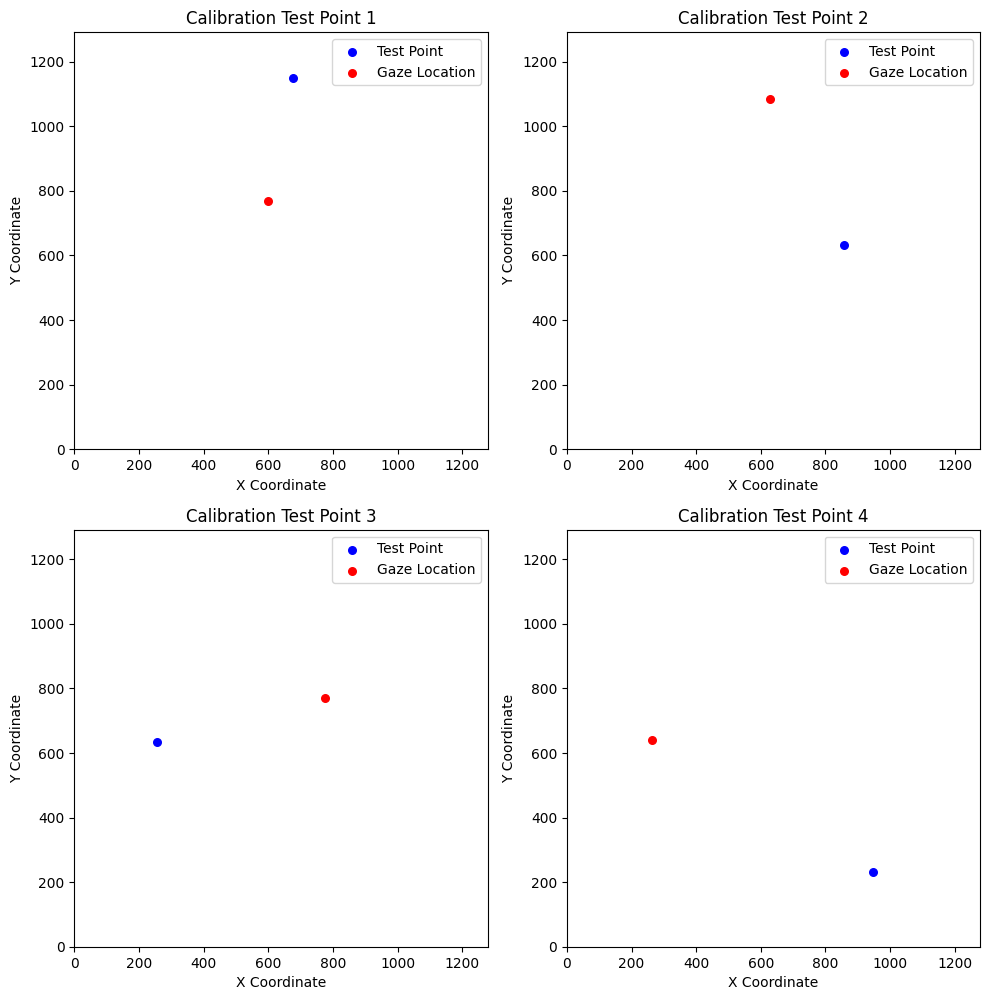

In [10]:
# Let's start by visualizing the user's screen and calibration process

# Function to convert percentages to absolute units
def convert_to_absolute(percentage, total):
    return float(percentage.strip('%')) / 100 * total

# Extract calibration points and convert them
calibration_points = [(convert_to_absolute(p['x'], calibration_session_data['windowInnerWidth']),
                       convert_to_absolute(p['y'], calibration_session_data['windowInnerHeight']))
                      for p in calibration_session_data['testPoints']]

gaze_locations = calibration_session_data['recordedGazeLocations']

# Calculate grid size for subplots
num_subplots = len(calibration_points)
grid_size = math.ceil(math.sqrt(num_subplots))

# Calculate scaled figure size
aspect_ratio = calibration_session_data['windowInnerWidth'] / calibration_session_data['windowInnerHeight']
subplot_width = 5  # Width of each subplot in inches
subplot_height = subplot_width / aspect_ratio  # Height, maintaining aspect ratio

# Create a figure with a grid of subplots
fig, axs = plt.subplots(grid_size, grid_size, figsize=(subplot_width * grid_size, subplot_height * grid_size))

# Flatten the array of axes (for easy iteration in case of a 2D array)
axs = axs.flatten()

s = 30
# Plot data in each subplot
for i in range(num_subplots):
    axs[i].scatter(*calibration_points[i], color='blue', label='Test Point', s=s, marker='o')
    axs[i].scatter(*gaze_locations[i], color='red', label='Gaze Location', s=s, marker='o')
    axs[i].set_xlabel('X Coordinate')
    axs[i].set_ylabel('Y Coordinate')
    axs[i].set_title(f'Calibration Test Point {i+1}')
    axs[i].legend()
    axs[i].set_xlim([0, calibration_session_data['windowInnerWidth']])
    axs[i].set_ylim([0, calibration_session_data['windowInnerHeight']])

# Hide any unused subplots
for i in range(num_subplots, len(axs)):
    axs[i].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


#### Visualizing Confidence Ellipse

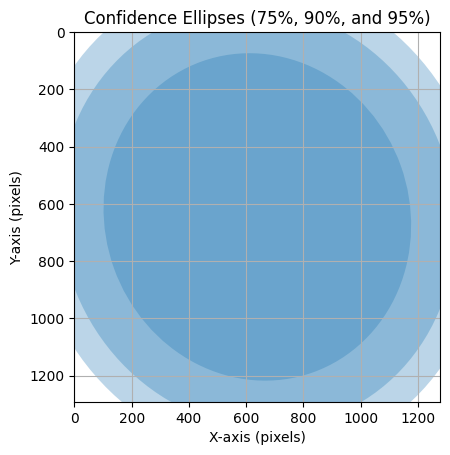

In [11]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Confidence ellipse data
rotation_angle_degrees = calibration_session_data['rotationAngleDegrees']
semimajor_axis_lengths = [calibration_session_data['semimajorAxisLength75'],
                          calibration_session_data['semimajorAxisLength90'],
                          calibration_session_data['semimajorAxisLength95']]
semiminor_axis_lengths = [calibration_session_data['semiminorAxisLength75'],
                          calibration_session_data['semiminorAxisLength90'],
                          calibration_session_data['semiminorAxisLength95']]
confidence_levels = [75, 90, 95]

# Create a figure and axis
fig, ax = plt.subplots()

# Plot confidence ellipses for different confidence levels
for i in range(len(confidence_levels)):
    semimajor = semimajor_axis_lengths[i]
    semiminor = semiminor_axis_lengths[i]
    angle = rotation_angle_degrees

    # Create an ellipse patch
    ellipse = Ellipse((calibration_session_data['windowInnerWidth']/2, calibration_session_data['windowInnerHeight']/2), width=semimajor * 2, height=semiminor * 2, angle=angle, alpha=0.3)

    # Add the ellipse to the plot
    ax.add_patch(ellipse)

# Set axis limits and labels
ax.set_xlim([0, calibration_session_data['windowInnerWidth']])
ax.set_ylim([0, calibration_session_data['windowInnerHeight']])
ax.set_xlabel('X-axis (pixels)')
ax.set_ylabel('Y-axis (pixels)')
ax.invert_yaxis()

# Set aspect ratio to 'equal' for a circular appearance
ax.set_aspect('equal')

# Show the plot
plt.title('Confidence Ellipses (75%, 90%, and 95%)')
plt.grid()
plt.show()


### Media Data

In [12]:
# Now let's look at the media viewing data
media_session = df_g[df_g['dataType'] == 'media']
media_session_data = media_session['data_obj'].iloc[0]
video_url = media_session_data["videoUrl"]
# Print the object and values. pprint for pretty printing
pprint.pprint(media_session_data)

{'containerHeight': 511,
 'containerWidth': 1278,
 'gazeCollectionResolution': 100,
 'isVideoEnded': True,
 'isVideoPlaying': False,
 'markdown': '<h2>Play the content below...</h2>\n',
 'recordedGazeLocations': [[514, 372],
                           [569, 157],
                           [642, 251],
                           [259, 1141],
                           [521, 1165],
                           [680, 293],
                           [624, 407],
                           [26, 297],
                           [245, 268],
                           [94, 293],
                           [-2, 304],
                           [2, 155],
                           [224, 270],
                           [259, 347],
                           [294, 351],
                           [17, 537],
                           [23, 582],
                           [565, 205],
                           [599, 63],
                           [526, 341],
                           [615, 1017],


### Download Media via. AWS

In [15]:
s3 = boto3.client('s3', aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_access_secret)

import os
# The name of your S3 bucket
bucket_name = 'brain-gaze-video-bucket'

# The S3 key of your file
file_name_s3 = os.path.basename(video_url)

# The path to the local file where you want to download the S3 object
local_file_name = 'eagle-stock-video.mp4'

# Download the file
s3.download_file(bucket_name, file_name_s3, local_file_name)

print(f"Downloaded {file_name_s3} from S3 bucket {bucket_name} to local file {local_file_name}")

Downloaded eagle-stock-video.mp4 from S3 bucket brain-gaze-video-bucket to local file eagle-stock-video.mp4


#### Media View Screen with Plotted Gaze Locations

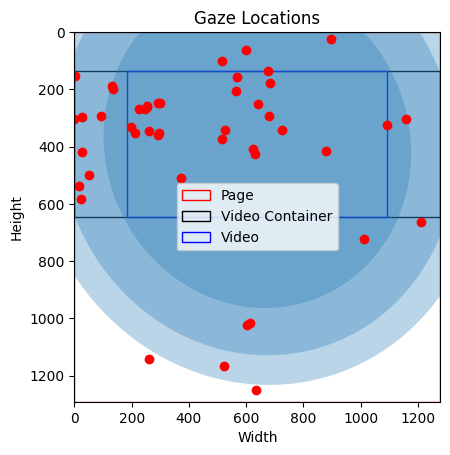

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

gaze_locations_video_coordinates = [] # We'll make new gaze locations within the video frame.

gaze_locations = np.array(media_session_data['recordedGazeLocations'])
videoOffsetX, videoOffsetY = media_session_data['videoOffsetWidth'], media_session_data['videoOffsetHeight']
videoContainerWidth, videoContainerHeight = media_session_data['containerWidth'], media_session_data['containerHeight']
windowInnerWidth, windowInnerHeight = media_session_data['windowInnerWidth'], media_session_data['windowInnerHeight']

# Open the video file using OpenCV
cap = cv2.VideoCapture(video_url)
# Get the video width and height from the video file
video_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
video_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

displayed_video_height = videoContainerHeight
aspect_ratio = video_width / video_height
displayed_video_width = displayed_video_height * aspect_ratio

# Calculate the offset due to centering the video in the container (if applicable)
offsetX = (windowInnerWidth - displayed_video_width) / 2
# offsetY = (windowInnerHeight - displayed_video_height) / 2
offsetY = videoOffsetY

# Adjust gaze locations relative to the video
# adjusted_gaze_locations = (gaze_locations - [offsetX, offsetY]) / scale

# Plotting
fig, ax = plt.subplots()

# Draw the page
page = patches.Rectangle((0, 0), windowInnerWidth, windowInnerHeight, linewidth=1, edgecolor='r', facecolor='none', label='Page')
ax.add_patch(page)

# Draw the video container
video_area = patches.Rectangle((videoOffsetX, videoOffsetY), videoContainerWidth, videoContainerHeight, linewidth=1, edgecolor='black', facecolor='none', label='Video Container')
ax.add_patch(video_area)

# Draw the video area
video_area = patches.Rectangle((offsetX, offsetY), displayed_video_width, displayed_video_height, linewidth=1, edgecolor='b', facecolor='none', label='Video')
ax.add_patch(video_area)

for i in range(len(confidence_levels)):
    semimajor = semimajor_axis_lengths[i]
    semiminor = semiminor_axis_lengths[i]
    angle = rotation_angle_degrees

    # Create an ellipse patch
    ellipse = Ellipse((offsetX + displayed_video_width / 2,
                       offsetY + displayed_video_height / 2),
                       width=semimajor * 2,
                       height=semiminor * 2,
                       angle=angle, alpha=0.3)

    # Add the ellipse to the plot
    ax.add_patch(ellipse)


# Plot recorded gaze locations on the video
for gaze_x, gaze_y in gaze_locations:

    # Plot the gaze point on the video
    ax.scatter(gaze_x, gaze_y, c='red', marker='o')

    gaze_x_video = (gaze_x - offsetX) * (video_width / displayed_video_width)
    gaze_y_video = (gaze_y - offsetY) * (video_height / displayed_video_height)
    gaze_locations_video_coordinates.append([gaze_x_video, gaze_y_video])

    # # We'll also create a gaze locations in video coordinates...
    # # TODO: Use 95% confidence ellipse to calculate whether the ellipse is in the box, not just the ctr point.
    # if(gaze_x < offsetX + displayed_video_width - semimajor_axis_lengths[-1] and
    #    gaze_x > offsetX and
    #    gaze_y < offsetY + displayed_video_height and
    #    gaze_y > offsetY):
    #     gaze_x_video = (gaze_x - offsetX) * (video_width / displayed_video_width)
    #     gaze_y_video = (gaze_y - offsetY) * (video_height / displayed_video_height)
    #     gaze_locations_video_coordinates.append([gaze_x_video, gaze_y_video])
    # else:
    #   gaze_locations_video_coordinates.append([-1,-1])


# Setting the aspect ratio to be equal to ensure square pixels
ax.set_aspect('equal', 'box')

plt.xlabel('Width')
plt.xlim([0, windowInnerWidth])
plt.ylim([0, windowInnerHeight])
plt.ylabel('Height')
plt.title('Gaze Locations')
plt.legend()
ax.invert_yaxis()

plt.show()

#### Basic Video Visualization over Time

In [154]:
# Now, let's make a video to visualize the gaze locations.
import cv2

output_path = 'output_video_basic.mp4'  # Path for the output video

# Load video
cap = cv2.VideoCapture(video_url)
if not cap.isOpened():
    print("Error: Could not open video.")
    raise Exception("Could not open video.")

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# Create a video writer for the output video
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Process gaze data
gaze_locations = np.array(gaze_locations_video_coordinates)
timestamps = np.array(media_session_data['recordedVideoTimestamps'])
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
video_duration = frame_count / fps

# Iterate over each frame
frame_idx = 0
with tqdm.tqdm(total=frame_count) as pbar:
  while cap.isOpened():
      ret, frame = cap.read()
      if not ret:
          break

      # Current time of the video in seconds
      current_time = frame_idx / fps

      # Find the closest timestamp in the gaze data
      closest_idx = np.argmin(np.abs(timestamps - current_time))
      gaze_x, gaze_y = gaze_locations[closest_idx]

      if not (gaze_x  == -1 and gaze_y == -1):
        # Overlay the gaze point on the frame
        cv2.circle(frame, (int(gaze_x), int(gaze_y)), 50, (0, 0, 255), -1)
        # print(f"Writing point for frame {frame_idx}")

      # Write the frame
      out.write(frame)
      frame_idx += 1

      pbar.update(1)

# Release everything
cap.release()
out.release()
cv2.destroyAllWindows()

  4%|▎         | 34/923 [00:03<01:21, 10.90it/s]


KeyboardInterrupt: ignored

#### Confident Gaze Vignette - Prototype 1


In [15]:
# Okay, now let's make the visualization with a confidence ellipse ..

Time to process 1 1920x1080 frame: 22.470360040664673


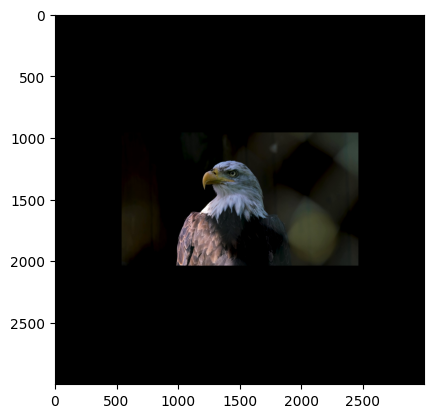

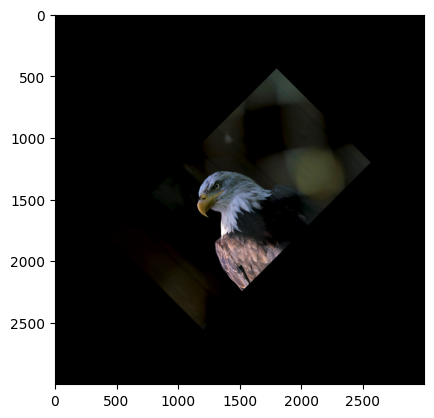

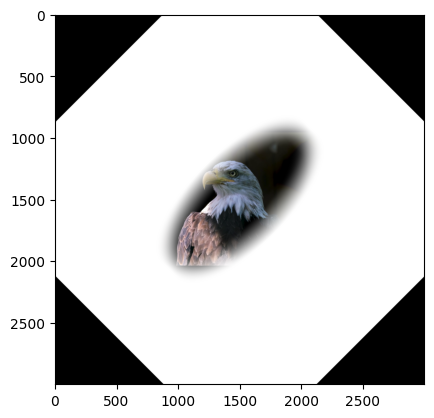

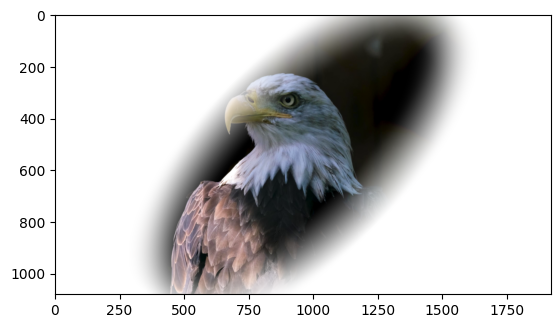

In [17]:
# Now, let's make a video to visualize the gaze locations.
import time
import numpy as np
import cv2
from wand.image import Image

output_path = 'output_video_confidence.mp4'  # Path for the output video

# Load video
cap = cv2.VideoCapture(video_url)
if not cap.isOpened():
    print("Error: Could not open video.")
    raise Exception("Could not open video.")

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# Create a video writer for the output video
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Process gaze data
gaze_locations = np.array(gaze_locations_video_coordinates)
timestamps = np.array(media_session_data['recordedVideoTimestamps'])
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
video_duration = frame_count / fps


test = True

# Iterate over ONE frame
frame_idx = 0
if cap.isOpened():
  ret, frame = cap.read()

  if not ret:
      raise Exception("Could not read video frame")

  # Current time of the video in seconds
  current_time = frame_idx / fps

  # Find the closest timestamp in the gaze data
  closest_idx = np.argmin(np.abs(timestamps - current_time))
  gaze_x, gaze_y = gaze_locations[closest_idx]

  if test:
    t0 = time.time()
    factor = 1/2 # for saving memory
    rotation_angle = 45
    radius = 100
    sigma = 100
    gaze_x = 500
    gaze_y = 500
    height, width = frame.shape[:2]

    new_height = int(height * factor)
    new_width = int(width * factor)
    new_gaze_x = int(gaze_x * factor)
    new_gaze_y = int(gaze_y * factor)

    # Use OpenCV's resize function to downsample the image
    frame = cv2.resize(frame, (new_width, new_height))

    height, width = new_height, new_width

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # 1. Pad the image on all sides
    pad_x, pad_y = int(width / 2), int(height / 2)
    padded_image = cv2.copyMakeBorder(frame, pad_x, pad_x, pad_y, pad_y, cv2.BORDER_CONSTANT, value=(0, 0, 0))

    # 2. Rotate the image
    rotation_matrix = cv2.getRotationMatrix2D((padded_image.shape[1] / 2, padded_image.shape[0] / 2), rotation_angle, 1)
    rotated_image = cv2.warpAffine(padded_image, rotation_matrix, (padded_image.shape[1], padded_image.shape[0]))

    rgb_bytes = cv2.imencode('.png', rotated_image)[1].tobytes()

    # Create a Wand image from the byte buffer
    wand_image = Image(blob=rgb_bytes)

    wand_image.vignette(radius=radius, sigma=sigma, x= pad_x + new_gaze_x, y= pad_y + new_gaze_y)

    opencv_image = None
    # Assuming wand_image is your Wand Image object
    with wand_image.convert('RGB') as converted:
        # Check the number of channels in the image
        channels = 4 if converted.alpha_channel else 3

        # Export the pixels with the appropriate format
        export_format = 'BGRA' if channels == 4 else 'BGR'
        raw_data = converted.export_pixels(channel_map=export_format)

        # Create a NumPy array of the raw data
        img_array = np.array(raw_data).reshape((converted.height, converted.width, channels))

        # If there's an alpha channel, drop it for OpenCV compatibility
        if channels == 4:
            img_array = img_array[:, :, :3]

        # Convert from RGB to BGR (OpenCV format)
        opencv_image = img_array.astype(np.uint8) #cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)

    # 3. Rotate the image back to the original orientation
    reverse_rotation_matrix = cv2.getRotationMatrix2D((opencv_image.shape[1] / 2, opencv_image.shape[0] / 2), -rotation_angle, 1)
    rotated_back_image = cv2.warpAffine(opencv_image, reverse_rotation_matrix, (opencv_image.shape[1], opencv_image.shape[0]))

    # 4. Crop the image back to its original size
    original_size = frame.shape[:2]
    cropped_image = rotated_back_image[pad_x:pad_x + original_size[0], pad_y:pad_y + original_size[1]]

    print(f"Time to process 1 {width}x{height} frame: {time.time() - t0}")
    plt.figure()
    plt.imshow(padded_image)

    plt.figure()
    plt.imshow(rotated_image)

    plt.figure()
    plt.imshow(rotated_back_image)

    plt.figure()
    plt.imshow(cropped_image)

# Release everything
cap.release()
out.release()
cv2.destroyAllWindows()

#### Confident Gaze Vignette - Performance Video


In [16]:
# The method above takes too long to process and also does not allow for positioned gradient ellipses
# Let's create our own method for adding an eye tracking vignette

def create_elliptical_mask(image, gaze_x, gaze_y, semimajor, semiminor, angle, scale):
    """
    Create an elliptical vignette mask with the same size as the image.
    :param image: Input image
    :param scale: Scale of the ellipse, 1.0 would mean the ellipse fits the image exactly
    :return: Elliptical vignette mask
    """
    rows, cols = image.shape[:2]

    # Creating the mask with elliptical region set to 1
    mask = np.zeros_like(image, dtype=np.float32)
    cv2.ellipse(img=mask,
                center=(int(gaze_x), int(gaze_y)),
                axes=(int(semimajor), int(semiminor)),
                angle=angle,
                startAngle=0,
                endAngle=360,
                color=(1, 1, 1),
                thickness=-1)

    # Optional: Create a smooth transition to the edges (feathered edge)
    # Feather the edges using the standard deviation
    kernel_size = int(
        min(
            (calibration_session_data['standardDeviationX'] * (width / displayed_video_width) * 2 * scale,
             calibration_session_data['standardDeviationY'] * (height / displayed_video_height) * 2 * scale)
            )
        )  # Kernel size for the blur
    kernel_size = kernel_size if kernel_size % 2 == 1 else kernel_size + 1 # ksize must be odd
    blurred_mask = cv2.GaussianBlur(mask, (kernel_size, kernel_size), 0)

    return blurred_mask

def apply_vignette(image, mask):
    """
    Apply the vignette effect to the image using the mask.
    :param image: Input image
    :param mask: Vignette mask
    :return: Image with vignette applied
    """
    # Converting image to float for multiplication
    image_float = image.astype(np.float32) / 255
    # Applying the vignette mask
    vignetted_image = cv2.multiply(image_float, mask)
    # Converting back to 8-bit format
    return (vignetted_image * 255).astype(np.uint8)

t0 = time.time()

# Create the elliptical mask
mask = create_elliptical_mask(frame,
                              gaze_x = frame.shape[1]/2,
                              gaze_y = frame.shape[0]/2,
                              semimajor = semimajor_axis_lengths[-1] * (width / displayed_video_width), # Use 95% conf.
                              semiminor = semiminor_axis_lengths[-1] * (height / displayed_video_height),
                              scale=1,
                              angle=rotation_angle_degrees)

# Apply the vignette to the image
vignetted_image = apply_vignette(frame, mask)

print(f"Time to process 1 {width}x{height} frame: {time.time() - t0}")

# Display or save the result
plt.imshow(vignetted_image)

NameError: ignored

In [157]:
# Cool. Now let's make the video.

# Now, let's make a video to visualize the gaze locations.
import tqdm
import time
import cupy as cp
import numpy as np
import cv2
from wand.image import Image

output_path = 'output_video_confident_gaze_vignette.mp4'  # Path for the output video

# Load video
cap = cv2.VideoCapture(video_url)
if not cap.isOpened():
    print("Error: Could not open video.")
    raise Exception("Could not open video.")

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

scale = 1/16 # Low quality, fast processing

# Create a video writer for the output video
out = cv2.VideoWriter(output_path, fourcc, fps, (int(width * scale), int(height * scale)))

# Process gaze data
gaze_locations = np.array(gaze_locations_video_coordinates)
timestamps = np.array(media_session_data['recordedVideoTimestamps'])
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
video_duration = frame_count / fps

# Iterate over each frame
frame_idx = 0
with tqdm.tqdm(total=frame_count) as pbar:
  while cap.isOpened():

      ret, frame = cap.read()

      if not ret:
          break

      # frame =  np.resize(frame, [int(frame.shape[1] * scale), int(frame.shape[0] * scale)])
      frame = cv2.resize(frame, (0, 0), fx = scale, fy = scale)

      # Current time of the video in seconds
      current_time = frame_idx / fps

      # Find the closest timestamp in the gaze data
      closest_idx = np.argmin(np.abs(timestamps - current_time))

      gaze_x, gaze_y = np.array(gaze_locations[closest_idx]) * scale

      if not (gaze_x == -1 and gaze_y == -1):

          # Create a mask for the ellipses

          major_axis = int(semimajor_axis_lengths[i] * (width / displayed_video_width)) * scale
          minor_axis = int(semiminor_axis_lengths[i] * (height / displayed_video_height)) * scale

          # Create the elliptical mask
          mask = create_elliptical_mask(frame,
                                        gaze_x = gaze_x,
                                        gaze_y = gaze_y,
                                        scale = scale,
                                        semimajor = major_axis, # Use 95% conf.
                                        semiminor = minor_axis,
                                        angle=rotation_angle_degrees)

          # Apply the vignette to the image
          vignetted_image = apply_vignette(frame, mask)
          frame = vignetted_image

      # Write the frame
      out.write(frame)
      frame_idx += 1
      pbar.update(1)

# Release everything
cap.release()
out.release()


 17%|█▋        | 154/923 [00:07<00:36, 21.02it/s]


KeyboardInterrupt: ignored

In [17]:
(int(width * scale), int(height * scale))

(1920, 1080)

In [18]:
# Load video
cap = cv2.VideoCapture("output_video_confident_gaze_vignette.mp4")
if not cap.isOpened():
    print("Error: Could not open video.")
    raise Exception("Could not open video.")

In [19]:
vignetted_image.shape

(1080, 1920, 3)